# Monte Carlo Integration

We will see more numerical techniques for mapping distributions. We will learn the Monte Carlo (MC) Integration (another form of bootstrapping also known as area-based sampling) where we just sample a distribution and integrate by sampling. Given that the expectation values of moments are defined as

\begin{equation}
E[x^n p(x)] = \int_{-\infty}^{\infty} x^n p(x) dx = \frac{1}{N}\sum_{i=1}^N x_i^n
\end{equation}

where $x_i \in p(x)$, i.e., $x_i$ is sampled from the probability density function (PDF) $p(x)$. The issue is how to sample when we have a distribution, but do not know its analytic form.

We are entering into the "territory" of the so-called Markov Chain Monte Carlo (MCMC) methods. The simplest way to introduce is to turn out distribution into a 2D image and randomly sample points on the image, but a rule will be defined to label points in this space. To see how this works, we will look at the calculation of the integral of a quarter circle (radius=1). This area should give $a=\pi/4$. The procedure that will be coded is the following:

1. Sample randomly in $x \in [0,1]$. 
2. Sample randomly in $y \in [0,1]$.
3. Check to see if $x$ and $y$ are within our quarter circle, i.e., if $\sqrt{x^2+y^2}< 1$. 
4. Compute the number of samples within our quarter circle, compared to all points.

In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

#First let's just compute the area of a quarter circle with radius 1
def quarterarea(iN):
    area=0
    
    # making arrays for points inside and outside the circle
    lXin = np.array([])
    lYin = np.array([])
    lXout = np.array([])
    lYout = np.array([])
    for i0 in range(iN):
        #Sample X and Y
        pX = np.random.uniform(0,1)
        pY = np.random.uniform(0,1)
        #Check if its radius is in 1
        if math.sqrt(pX**2+pY**2) < 1:
            lXin = np.append(lXin,pX)
            lYin = np.append(lYin,pY)
            area += 1 # count it
        else:
            lXout = np.append(lXout,pX)
            lYout = np.append(lYout,pY)
    return (float(area)/float(iN)),lXin,lYin,lXout,lYout

#sample points
#lN=1000
lN=100000 #a finer sampling
a,lXin,lYin,lXout,lYout=quarterarea(lN)

# The uncertainty here is taken from a Poisson uncertainty which is the area/sqrt(N)
# We are sampling over a quarter of a circle and to extract pi, we need to multiply the MC area by 4.
print("Pi (4*area):",a*4,"+/-",4*a/math.sqrt(lN)) 
plt.plot(lXin,lYin,marker='.',linestyle = 'None')
plt.plot(lXout,lYout,marker='.',linestyle = 'None')
plt.show()


In [ ]:
# We can look at the distributions of X values inside and outside the circle (which is the result of the sampling)
# given the constraint defined by the area of the circle.

# Note on the underscore variable:
# The use of underscore below is for "throwaway variables": to indicate that part of a function result is being 
# deliberately ignored. One can also find underscore variables in loops like for _ in range(10): meaning that
# the index is being ignored.
# It can also be set for "internal use" so certain variables can be named without causing conflict to existing
# Python functions or built-ins. For example, one can define a variable def_ so it does not conflict with the command
# def in defining functions.
_,bins,_=plt.hist(lXin,bins=10,alpha=0.5,density=True, label='below')
plt.hist(lXout,alpha=0.5,bins=bins,density=True, label='above')
plt.legend(loc=1)
plt.xlabel("X")
plt.ylabel("Density")
plt.show();

print("Result of the sampling:")
print("number below:",len(lXin),"number above:",len(lXout))
#Note, these numbers will be slightly different for each run
#due to random generation of data


The idea with Monte Carlo integration is that we calculate an integral by evaluating the function itself without having to rely on specific integration methods such as Trapezoid, Simpson's rule, etc. 

Now, let's see how this work for some arbitrary function $y=f(x)$. We will try a more complicated function with minima and maxima in their outline. As we did with the circle example, we can compute the integral by plotting this function over a range, here we will do $−6<x<3$. 

The code will first locate the maximum and minimum values of $y$, so we can also restrict the sampling over $y$ accordingly. The code will therefore sample $x$ and $y$ from a uniform distribution within the minima and maxima values identified. Then we will check if the $y$ sampled point is below or above the curve by setting the condition:

`Calculate y (in principle the minimum until we compare with y_sampled) y_min = f(x_sampled)`

`if y_sampled < y_min --> y_sampled is below the curve.`

We will also try a different initial sampling rather than the uniform distribution which is to sample $x$ and $y$ from a normal distribution. <b>Do you think the final distributions will be significantly affected when we change to a normal sampling?</b>

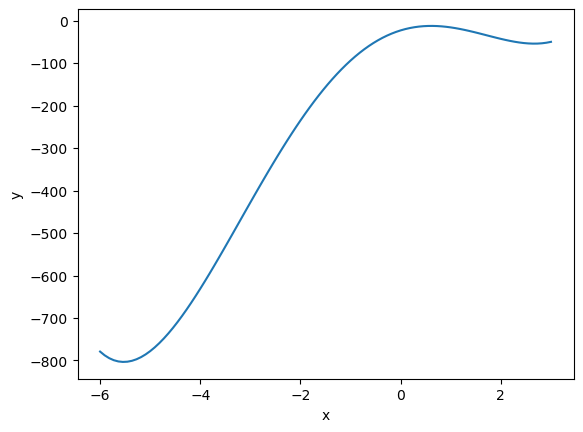

[ymin,ymax]: -803.3955308824272 -12.499898490291134


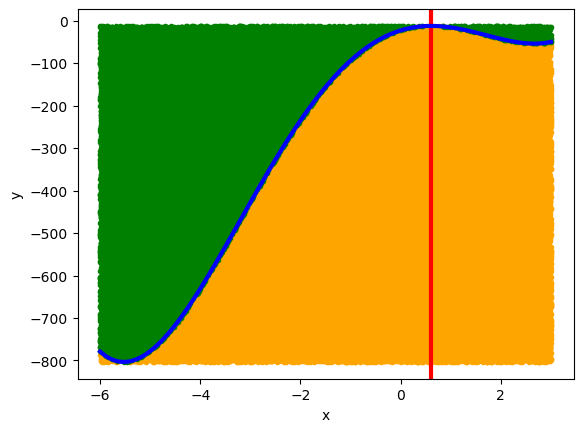

In [3]:
from scipy import optimize as opt 

#use this random seed
np.random.seed(10)

#Now let's consider integrating some random function
def f(x):
    return x**4 + 3*(x-2)**3 - 15*(x)**2 + 1

#Now let's multiply it by -1 to make the range calculation fast
def fneg(x):
    return -1*(x**4 + 3*(x-2)**3 - 15*(x)**2 + 1)

#First thing is to define a range in x
xmin=-6
xmax=3
x = np.linspace(xmin, xmax, 100)
plt.figure()
plt.plot(x, f(x))
plt.xlabel('x')
plt.ylabel('y')
plt.show()

#Now we need to find a range in y
# From the manuals, https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize_scalar.html
# The default method is the "Bounded" Brent method if bounds are passed and unbounded "Brent" otherwise.
sol=opt.minimize_scalar(f,bounds=(xmin, xmax), method='Bounded')
ymin=sol.fun
#y-max is to get the minimum of negative f
sol=opt.minimize_scalar(fneg,bounds=(xmin, xmax), method='Bounded')
ymax=-1*sol.fun
print('[ymin,ymax]:', ymin, ymax)

lN=100000
#now, let's sample a 2D grid y-min and y-max and compute the integral
lXin = np.array([])
lYin = np.array([])
lXout = np.array([])
lYout = np.array([])
for i0 in range(lN):
    #Try a uniform distribution
    pX = abs(xmax-xmin)*np.random.uniform(0,1)+xmin
    pY = abs(ymax-ymin)*np.random.uniform(0,1)+ymin
    #Try a normal distribution
    #pX = abs(xmax-xmin)*np.random.normal(0,1)+xmin
    #pY = abs(ymax-ymin)*np.random.normal(0,1)+ymin
    pYMin = f(pX)
    if pY < pYMin:
        lXin = np.append(lXin,pX)
        lYin = np.append(lYin,pY)
    else:
        lXout = np.append(lXout,pX)
        lYout = np.append(lYout,pY)

plt.figure()
plt.plot(lXin,lYin,marker='.',linestyle = 'None', color='orange')
plt.plot(lXout,lYout,marker='.',linestyle = 'None', color='green')
plt.axvline(sol.x, c='red', lw=3)
plt.plot(x, f(x), 'b-', lw=3)
plt.xlabel("x")
plt.ylabel("y")
# uncomment these two lines for Gaussian sampling
#plt.ylim(-800,0)
#plt.xlim(-6,3)
plt.show();


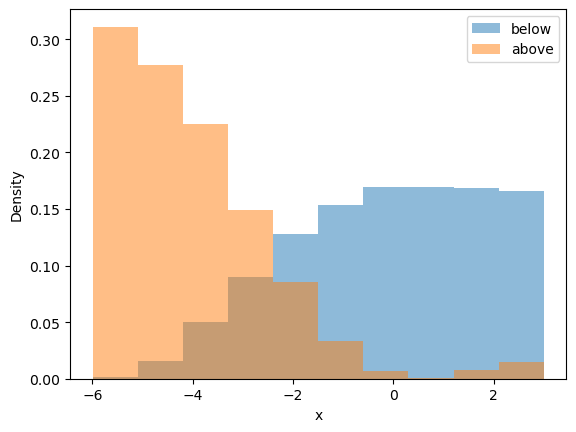

Result of the sampling:
number below: 64253 number above: 35747


In [7]:
# We can look at the distributions of X values inside and outside the circle (which is the result of the sampling)
# given the constraint defined by the area of the circle.
_,bins,_=plt.hist(lXin,bins=10,alpha=0.5,density=True, label='below')
plt.hist(lXout,alpha=0.5,bins=bins,density=True, label='above')
#plt.xlim(-6,3)
plt.legend(loc=1)
plt.xlabel("x")
plt.ylabel("Density")
plt.show();

print("Result of the sampling:")
print("number below:",len(lXin),"number above:",len(lXout))
#Note, these numbers will be slightly different for each run
#due to random generation of data


There are many other ways to sample points (or data) from this method. For instance, one can set conditions to get points that are nearby a function, or you may want to sample points that avoid the tails of the function, and many other criteria that can be defined. In summary, when we adopt MC area-based sampling, we can sample points and data for whatever function we wish.

Note that we have to be careful with this method of finding an integral if we are sampling, for example, from a Gaussian distribution. In that case, our sampling would be biased by the Gaussian we chose, which means our integral will not be correct. Yet, for the sake of sampling, the MC area-based sampling using the Gaussian can be adopted (and not to calculate a precise integral value). That is because we can write the integral in general form as

\begin{equation}
I = \int_{\Omega} f(x,y)p(x,y)dx dy
\end{equation}

in which $\Omega$ is the phase space, $f(x,y)$ is an arbitrary function which we could obtain its integral and $p(x,y)$ is a probability density function. If $p(x,y)$ is an uniform distribution, the pure integral of $f(x,y)$ can be obtained, but if $p(x,y)$ is a Gaussian distribution, than that will give a weighted (biased) integral of $f(x,y)$.

# Markov Chains

A Markov chain or Markov process is a stochastic process describing a sequence of possible events in which the probability of each event depends only on the state attained in the previous event. They provide the basis for general stochastic simulation methods known as Markov Chain Monte Carlo (MCMC), which are used for simulating sampling from complex probability distributions as we just have seen.

Random walks are examples of Markov processes which can be easily coded as below (source: https://people.duke.edu/~ccc14/sta-663-2018/notebooks/S10B_MarkovChains.html)

In [ ]:
n = 1000 # number of walks
k = 100 # number of time steps

# This is a discrete random walk process in which the walker can only move up (+1) or down (-1)
xs = np.c_[np.zeros(n), np.random.choice([-1,1], (n, k))] # Translates slice objects to concatenation along the second axis.
xs = np.cumsum(xs, axis=1) # this uses cumulative sum over all the walks

for x in xs:
    plt.plot(np.arange(k+1), x)
    plt.xlabel('index')
    plt.ylabel('Displacement')

In [ ]:
# We can take snapshots of displacement after k time steps and see
# that they follow a normal distribution with sigma = sqrt(k)

fig, axes = plt.subplots(1, 5, figsize=(15, 3), sharex=True)
for i, k in enumerate(range(20, 101, 20)):
    axes[i].hist(xs[:, k], alpha=0.3, density=True)
    axes[i].set_title('t = %d' % k)
    xp = np.linspace(-25, 25, 100)
    axes[i].plot(xp, stats.norm(loc=0, scale=np.sqrt(k)).pdf(xp))
    
plt.tight_layout()

<b>Example: Stock Price Simulation (Markov Process based)</b>

Source: https://drbeane.github.io/_pages/courses/dsci303/21%20-%20Random%20Number%20Generation.html

One can create a function that generates simulated prices for a stock over a period of several days. Let's define a <b>yield rate</b> for a stock is the percentage increase or decrease in the value of the stock over a certain period. Suppose that the price of a stock today is \\$100 and the stock has a yield rate of 12\% over the next year. Then the price of the stock at the end of the year will be $100\exp\{0.12\} = 112.75$.

Let $S_0$ denote the current price of a stock. Suppose that we randomly generate simulated daily yield rates for the stock over the next $n$ days. Denote these simulated rates as $R_1$, $R_2$,...,$R_n$. Let $S_t$ denote the price of the stock at the end of day $t$. Then we will simulate value of $S_t$ as $S_t=S_0 e^R_1 e^R_2\dots e^R_t$, or  $S_t=S_0 e^{R_1+R_2+\dots +R_t}$. We can then define the cumulative yield rate on day $t$ as $CR_t=R_1+R_2+\dots+R_t$. Therefore, the formula for the simulated price on day $t$ is simply $S_t=S_0 e^{CR_t}$.

We will now create a function that simulates a sequence of several daily prices for a stock. We will assume that the stock price will see a percentage change equal to one of the following amounts each day:

-0.5\%, -0.4\%, -0.3\%, -0.2\%, -0.1\%, 0\%, 0.1\%, 0.2\%, 0.3\%, 0.4\%, 0.5\% 

and we will assume that each of these changes is equally likely.

In [ ]:
def sim_stock(start=100, n=100):
    
    rate_choices = [-0.005, -0.004, -0.003, -0.002, -0.001, 0, 0.001, 0.002, 0.003, 0.004, 0.005]
    daily_yields = np.random.choice(rate_choices, n)
    
    cumulative_yields = np.cumsum(daily_yields)
    daily_multipliers = np.exp(cumulative_yields)

    daily_prices = start * daily_multipliers

    daily_prices = np.concatenate(([start], daily_prices))
    
    return np.round(daily_prices,2)

In [ ]:
#Let's generate a sequence of 10 simulated daily prices for a stock currently work at $50.
print(sim_stock(start=50, n=10))

In [ ]:
# Plot the simulated daily prices of a stock currently worth $100 over the course of a year. 
# There are 252 trading days in a year, so we will use n=252.

plt.plot(sim_stock(100, 252))
plt.xlabel("Trading days")
plt.ylabel("Daily Price")
plt.show()

In [ ]:
# To get a sense of the range of possible outcomes for our stock model after one year, 
# let's plot 1000 simulated sequences, or runs, of daily stock prices.

for i in range(1000):
    plt.plot(sim_stock(100, 252))
    plt.xlabel("Trading days")
    plt.ylabel("Daily Price")
plt.show()

In [ ]:
# We can create 10,000 simulations for the price of the stock over the course of a year. 
# We then use these simulations to estimate the probability that the price of the stock will 
# be greater than 105 a year from now.

final_prices = []
for i in range(100000):
    run = sim_stock(100,365)
    final_prices.append(run[-1])
final_prices = np.array(final_prices)

# final_prices > 105 creates a boolean array where each entry is True if the corresponding stock price 
# is greater than 105, and False otherwise. Then, np.mean computes the average of this boolean array. 
# Since True is treated as 1 and False as 0, the mean of this array represents the fraction of simulations 
# where the final price was greater than 105.
print("Probability:", np.mean(final_prices > 105))